In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score

Load data

In [3]:
!pip install kagglehub
import kagglehub


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
# Download latest version
path = kagglehub.dataset_download("spscientist/students-performance-in-exams")

print("Path to dataset files:", path)

100%|██████████████████████████████████████| 8.70k/8.70k [00:00<00:00, 5.42MB/s]

Extracting files...
Path to dataset files: /Users/admin/.cache/kagglehub/datasets/spscientist/students-performance-in-exams/versions/1


In [10]:
#set the path
data_path = "/Users/admin/.cache/kagglehub/datasets/spscientist/students-performance-in-exams/versions/1"

#list files in that path
print(os.listdir(data_path))


['StudentsPerformance.csv']


In [11]:
#load data
student = pd.read_csv(os.path.join(data_path, "StudentsPerformance.csv"))
print(student.head())

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  


So here I am trying to predict race from math, reading and writing scores. So my Target id race and my features are math reading and writing. Math reasing and writing are numerical, and my ethnicity are groups. So multiclassification by numerical probably.

In [13]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


No missing values.

In [15]:
student.duplicated().sum()

0

No duplicates.

In [16]:
#unique values in the target column
print(student['race/ethnicity'].unique())

#count of each
print(student['race/ethnicity'].value_counts())

['group B' 'group C' 'group A' 'group D' 'group E']
race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64


Okay so there is 5 classes, also class A is very little.

array([[<Axes: title={'center': 'math score'}>,
        <Axes: title={'center': 'reading score'}>],
       [<Axes: title={'center': 'writing score'}>, <Axes: >]],
      dtype=object)

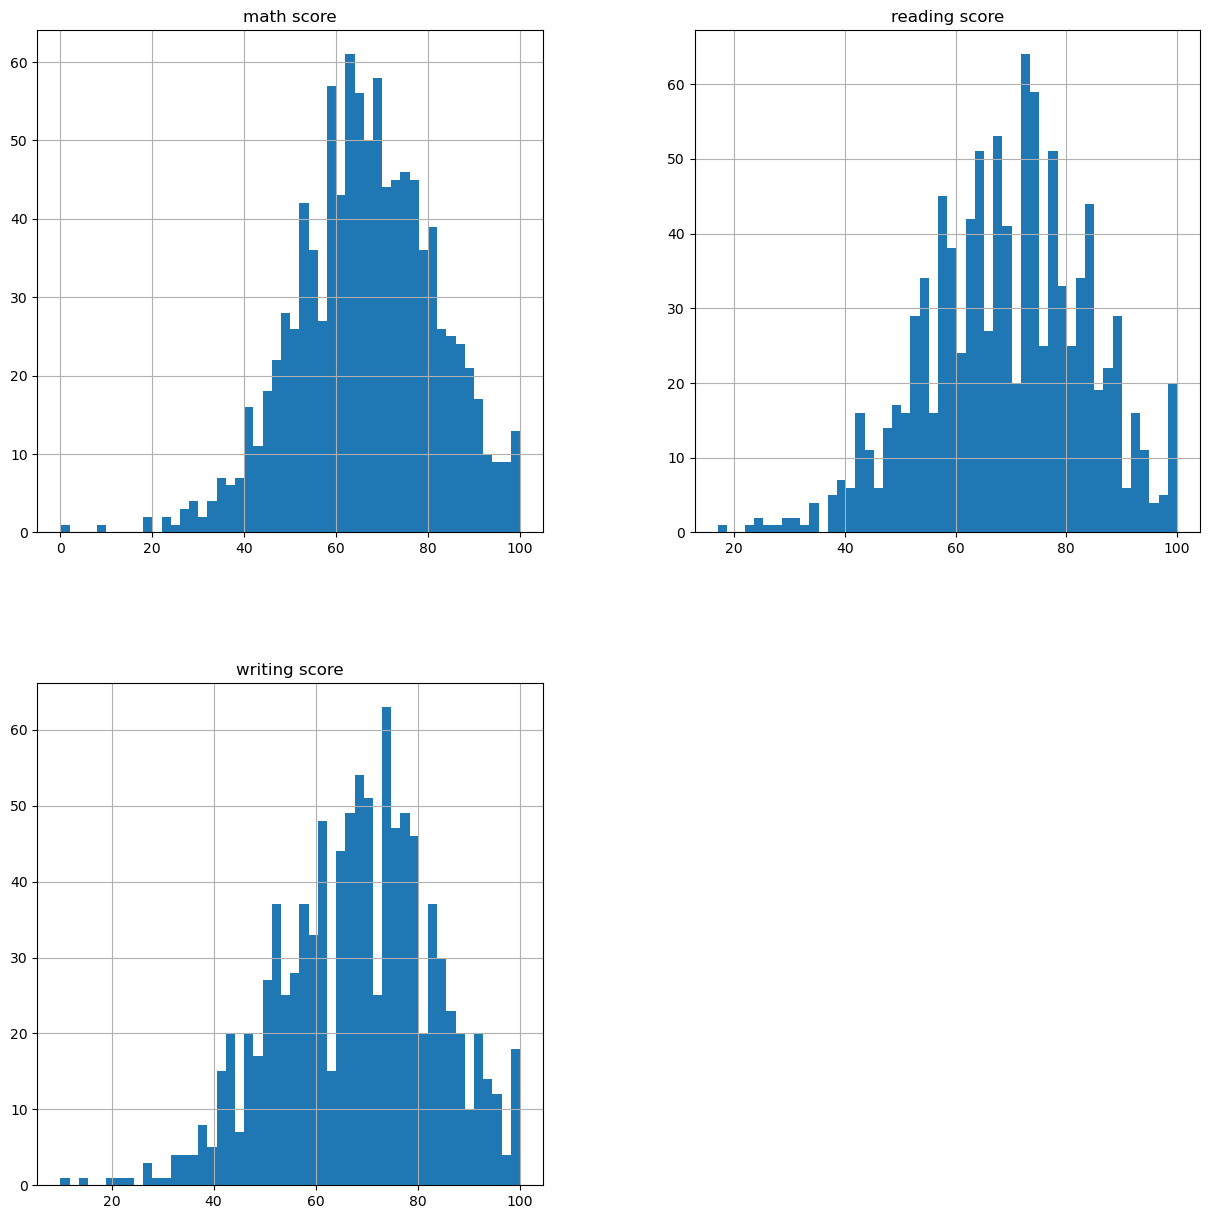

In [17]:
student.hist(bins=50, figsize=(15, 15))

Pretty normal distributed.

In [21]:
#lets start with a standard logistic regression and see how that performs
#recode the classes
le = LabelEncoder()
student['race_encoded'] = le.fit_transform(student['race/ethnicity'])
#check that it worked
le.classes_

array(['group A', 'group B', 'group C', 'group D', 'group E'],
      dtype=object)

In [22]:
#define features and target
X = student[['math score', 'reading score', 'writing score']]
y = student['race_encoded']

In [23]:
#time to split
#stratify because of A
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,         
    stratify=y,           
    random_state=10       
)

In [25]:
#lets scale to make the learning easier
scaler = StandardScaler()

#fit
X_train_scaled = scaler.fit_transform(X_train)

#transform test
X_test_scaled = scaler.transform(X_test)



In [29]:
#logistic regression with multinomial regression
model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000)

#fit on scaled training data
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [30]:
#predict
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     group A       0.15      0.44      0.23        18
     group B       0.13      0.08      0.10        38
     group C       0.31      0.08      0.12        64
     group D       0.38      0.35      0.36        52
     group E       0.23      0.50      0.31        28

    accuracy                           0.24       200
   macro avg       0.24      0.29      0.23       200
weighted avg       0.27      0.24      0.22       200



That is terrible lets do Ranom forrest.


In [34]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=10)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

              precision    recall  f1-score   support

     group A       0.11      0.06      0.07        18
     group B       0.22      0.18      0.20        38
     group C       0.27      0.33      0.29        64
     group D       0.27      0.33      0.29        52
     group E       0.38      0.21      0.27        28

    accuracy                           0.26       200
   macro avg       0.25      0.22      0.23       200
weighted avg       0.26      0.26      0.25       200



In [ ]:
Thats also bad

In [44]:
svm_model = SVC( C=5,
    kernel='rbf',  
    class_weight='balanced',              
    probability=True,         
    random_state=10
)

svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

              precision    recall  f1-score   support

     group A       0.17      0.67      0.27        18
     group B       0.25      0.11      0.15        38
     group C       0.50      0.20      0.29        64
     group D       0.29      0.17      0.22        52
     group E       0.19      0.39      0.26        28

    accuracy                           0.24       200
   macro avg       0.28      0.31      0.24       200
weighted avg       0.33      0.24      0.24       200



SVM with rbf is better than previous models. 


In [41]:
# Initialize the model
xgb_model = XGBClassifier(
    n_estimators=10,   
    eval_metric='mlogloss',     
    random_state=10
)

#fit on raw X_train and y_train
xgb_model.fit(X_train, y_train)

#predict
y_pred_xgb = xgb_model.predict(X_test)

#eval
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))


              precision    recall  f1-score   support

     group A       0.00      0.00      0.00        18
     group B       0.35      0.16      0.22        38
     group C       0.35      0.58      0.43        64
     group D       0.34      0.37      0.35        52
     group E       0.28      0.18      0.22        28

    accuracy                           0.34       200
   macro avg       0.26      0.26      0.24       200
weighted avg       0.30      0.34      0.30       200



Even more horrible Okay lets move on.

In [45]:
import pickle

#save trained SVM model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

#save StandardScaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
